# 无监督异常检测的知识蒸馏


本笔记本实践了**无监督异常检测**中的知识蒸馏方法。

我们参考了论文 [*Student-Teacher Feature Pyramid Matching for Anomaly Detection*](https://arxiv.org/pdf/2103.04257) 及其[配套代码](https://github.com/xiahaifeng1995/STPM-Anomaly-Detection-Localization-master)。下图（来自该论文）展示了该方法的工作原理：

![stpm](./images/stpm.png)


## 主干网络与数据集的选择


### 主干网络与损失函数


该论文采用 [ResNet18](https://arxiv.org/pdf/1512.03385) 作为网络架构，**教师模型**在 [ImageNet](https://www.image-net.org/) 上预训练，**学生模型**使用相同架构但随机初始化权重。

如上图所示，损失函数基于 ResNet18 前三个**层组**的输出计算。每个层组包含处理相同图像分辨率的所有层。学生模型仅在这三个输出上学习复现教师模型的**特征图**。异常得分也基于这些输出计算。

使用的损失函数是**均方误差（MSE）**，即逐像素计算两个特征图的欧氏距离，再对所有特征图求和得到总损失：
$D(I_1, I_2) = \sqrt{\sum_{i=1}^{m} \sum_{j=1}^{n} \left( I_1(i,j) - I_2(i,j) \right)^2}$


### 数据集


论文使用的数据集是 [MVTEC AD](https://www.mvtec.com/company/research/datasets/mvtec-ad)，包含 **15 个类别**（10 个物体 + 5 个纹理）。每个类别约有 **350 张无缺陷图像**用于训练，**100 张有缺陷图像**用于测试。

数据集示例如下：
![mvtec](./images/mvtec.png)

可通过[此链接](https://www.mvtec.com/company/research/datasets/mvtec-ad)下载数据集。本实验将使用 **hazelnut（榛子）**类别。


## 使用 PyTorch 与 timm 实现


部分函数（如数据集加载）较为复杂，但理解核心概念并非必需。为保持清晰，这些辅助函数已移至 `utils.py`，可按需查阅。


In [1]:
import matplotlib.pyplot as plt
from utils import MVTecDataset,cal_anomaly_maps
import torch
import torch.nn as nn
import timm
import torch.nn.functional as F
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 数据集处理


首先加载数据集并查看其内容。
本次实验将训练集**显式划分**为训练子集与验证子集，以便在训练过程中评估模型性能。


In [2]:
train_dataset = MVTecDataset(root_dir="../data/mvtec/hazelnut/train/good",resize_shape=[256,256],phase='train')
test_dataset = MVTecDataset(root_dir="../data/mvtec/hazelnut/test/",resize_shape=[256,256],phase='test')
print("taille du dataset d'entrainement : ",len(train_dataset))
print("taille du dataset de test : ",len(test_dataset))
print("taille d'une image : ",train_dataset[0]['imageBase'].shape)

# Séparation du dataset d'entrainement en train et validation
img_nums = len(train_dataset)
valid_num = int(img_nums * 0.2)
train_num = img_nums - valid_num
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

# Création des dataloaders
train_loader=torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
val_loader=torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


taille du dataset d'entrainement :  391
taille du dataset de test :  110
taille d'une image :  (3, 256, 256)


可视化部分缺陷样本：


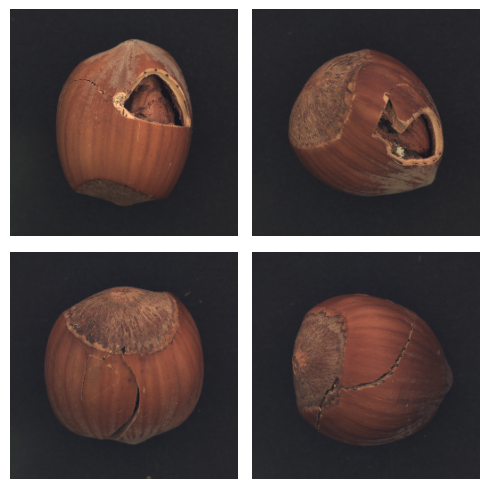

In [3]:
num_defects_displayed = 0
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

for sample in test_loader:
  image = sample['imageBase']
  has_defect = sample['has_anomaly']
  if has_defect:
    row = num_defects_displayed // 2
    col = num_defects_displayed % 2
    
    axes[row, col].imshow(image.squeeze().permute(1, 2, 0).numpy())
    axes[row, col].axis('off')  
    
    num_defects_displayed += 1
    
    if num_defects_displayed == 4:
      break
plt.tight_layout()
plt.show()

### 构建教师与学生模型


我们将使用**同一类**实现两个模型，通过参数区分教师/学生模型的特性。
为简化预训练主干网络的使用，我们采用 [timm](https://timm.fast.ai/) 库（PyTorch Image Models）。该库提供：
- 丰富的预训练主干网络与模型
- 灵活的网络操作接口


In [4]:
class resnet18timm(nn.Module):
    def __init__(self,backbone_name="resnet18",out_indices=[1,2,3],pretrained=True):
        super(resnet18timm, self).__init__()     
        # Features only permet permet de ne récupérer que les features et pas la sortie du réseau, out_indices permet de choisir les couches à récupérer
        self.feature_extractor = timm.create_model(backbone_name,pretrained=pretrained,features_only=True,out_indices=out_indices)
        if pretrained:
            # Si le modèle est pré-entrainé (donc c'est le teacher), on gèle les poids
            self.feature_extractor.eval() 
            for param in self.feature_extractor.parameters():
                param.requires_grad = False   
        
    def forward(self, x):
        features = self.feature_extractor(x)
        return features

现在可实例化**教师模型**与**学生模型**：


In [5]:
student=resnet18timm(backbone_name="resnet18",out_indices=[1,2,3],pretrained=False).to(device)
teacher=resnet18timm(backbone_name="resnet18",out_indices=[1,2,3],pretrained=True).to(device)

### 损失函数


损失函数采用**欧氏距离（MSE）**，定义为：
$D(I_1, I_2) = \sqrt{\sum_{i=1}^{m} \sum_{j=1}^{n} \left( I_1(i,j) - I_2(i,j) \right)^2}$，其中 $I_1$、$I_2$ 分别为教师/学生模型的特征图。

实现中，我们对**三组特征图对**分别计算该距离，并汇总为总体损失。


In [6]:
class loss_kdad:
  def __init__(self):
    pass
  # fs_list : liste des features du student et ft_list : liste des features du teacher
  def __call__(self,fs_list, ft_list):
    t_loss = 0
    N = len(fs_list)
    for i in range(N):
      fs = fs_list[i]
      ft = ft_list[i]
      _, _, h, w = fs.shape
      # Normaliser les features améliore les résultats
      fs_norm = F.normalize(fs, p=2)
      ft_norm = F.normalize(ft, p=2)

      # Calcul de la distance euclidienne
      f_loss = 0.5 * (ft_norm - fs_norm) ** 2
      # On prend la moyenne de la loss sur tous les pixels
      f_loss = f_loss.sum() / (h * w)
      t_loss += f_loss

    return t_loss / N

### 模型训练


设置超参数：


In [7]:
epochs= 20
lr=0.0004
criterion = loss_kdad()
optimizer = torch.optim.Adam(student.parameters(), lr=lr)

开始训练模型！（训练可能需较长时间）


In [8]:
for epoch in range(epochs):
    student.train()
    train_loss = 0.0
    for data in train_loader:
        image = data['imageBase'].to(device)
        optimizer.zero_grad()
        outputs_student = student(image)
        outputs_teacher = teacher(image)
        loss = criterion(outputs_student,outputs_teacher)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    student.eval()
    val_loss = 0.0
    for data in val_loader:
        image = data['imageBase'].to(device)
        outputs_student = student(image)
        outputs_teacher = teacher(image)
        loss = criterion(outputs_student,outputs_teacher)
        val_loss += loss.item()
    print("Epoch {} - train loss : {} - val loss : {}".format(epoch,train_loss/len(train_loader),val_loss/len(val_loader)))

Epoch 0 - train loss : 1.6731480107277255 - val loss : 1.3833315640687942
Epoch 1 - train loss : 0.8773692731238618 - val loss : 0.7371394574642182
Epoch 2 - train loss : 0.5567233881241158 - val loss : 0.5115290269255638
Epoch 3 - train loss : 0.4170471341172351 - val loss : 0.4163943402469158
Epoch 4 - train loss : 0.33714089627507365 - val loss : 0.3523293524980545
Epoch 5 - train loss : 0.29374887162371527 - val loss : 0.28786116763949393
Epoch 6 - train loss : 0.2577011583349373 - val loss : 0.2747397504746914
Epoch 7 - train loss : 0.2373752082827725 - val loss : 0.22077917009592057
Epoch 8 - train loss : 0.21801123603046696 - val loss : 0.2255100306123495
Epoch 9 - train loss : 0.2012799475577813 - val loss : 0.19499738812446593
Epoch 10 - train loss : 0.1874875887473927 - val loss : 0.20737174898386002
Epoch 11 - train loss : 0.17415884736029408 - val loss : 0.254209216684103
Epoch 12 - train loss : 0.16137944416532032 - val loss : 0.15532575249671937
Epoch 13 - train loss : 0.

训练完成后，我们使用 **AUROC 指标**评估模型（回顾见[第 9 课](../09_EntrainementContrastif/01_FaceVerification.ipynb)）。


In [11]:
scores = []
test_imgs = []
gt_list = []
for sample in test_loader:
    label=sample['has_anomaly']
    image = sample['imageBase'].to(device)
    test_imgs.extend(image.cpu())
    gt_list.extend(label.cpu().numpy())
    with torch.set_grad_enabled(False):
        
        outputs_student = student(image)
        outputs_teacher = teacher(image) 

        # La fonction cal_anomaly_maps permet de calculer la carte d'anomalie (ça sera utile pour la visualisation après)
        score =cal_anomaly_maps(outputs_student,outputs_teacher,256) 
        
    scores.append(score)
scores = np.asarray(scores)
gt_list = np.asarray(gt_list)

from sklearn.metrics import roc_auc_score

map_scores = np.asarray(scores)

max_anomaly_score = map_scores.max()
min_anomaly_score = map_scores.min()
map_scores = (map_scores - min_anomaly_score) / (max_anomaly_score - min_anomaly_score)
img_scores = map_scores.reshape(map_scores.shape[0], -1).max(axis=1)
gt_list = np.asarray(gt_list)
img_roc_auc = roc_auc_score(gt_list, img_scores)
print(" image hazelnut ROCAUC : %.3f" % (img_roc_auc))


 image hazelnut ROCAUC : 0.990


模型在榛子缺陷检测上取得**极高的 AUROC 分数**，表现优异。


### 异常热力图可视化


我们通过比较教师/学生模型在**三个不同尺度输出**上的特征图计算异常得分。使用 `cal_anomaly_maps` 函数：
1. 对每组特征图计算差异
2. 将差异映射回原始图像尺寸，生成**异常热力图**
3. 热力图可直观显示缺陷的**空间定位**


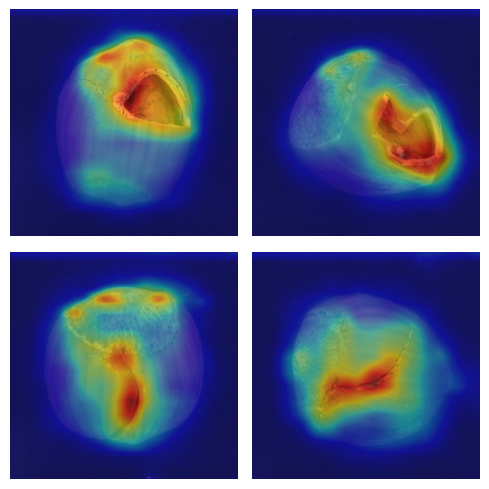

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(5, 5))

for i,(img,mask) in enumerate(zip(test_imgs,scores)):
    img_act=img.squeeze().permute(1, 2, 0).numpy()
    row = i // 2
    col = i % 2
    axs[row, col].imshow(img_act) 
    axs[row, col].imshow(mask, cmap='jet', alpha=0.5)
    axs[row, col].axis('off')
    if i==3:
        break
    
plt.tight_layout()
plt.show()


尽管定位并非模型的主要目标，但结果显示**缺陷定位已相当精确**。
